<a href="https://colab.research.google.com/github/Joycechidi/Deep-Learning-/blob/master/CNN/Malaria_Cell_Detection_Using_VGGNet_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Transfer Learning
In this notebook, I'll be using VGGNet trained on the ImageNet dataset as a feature extractor. 

I'm using VGGNet because it's simple and has great performance, coming in second in the ImageNet competition. 

All the convolutional layers will be kept but I will replace the final fully-connected layer with my own classifier. This way I can use VGGNet as a fixed feature extractor for my images then easily train a simple classifier on top of that.

*   Use all but the last fully-connected layer as a fixed feature extractor.
*   Define a new, final classification layer and apply it to a task of our choice!

I am trying to use the dataset containing infected and uninfected malaria cell images. Downloaded from Kaggle here [https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria/download]

### Objective
Build a convolutional neural network that can detect the presence of malaria parasite in blood cells.

After training this dataset with VGGNet, I will also train with ResNet pre-trained model and then compare the performance between the two models.

In [40]:
!pip install jupyter_contrib_nbextensions

In [41]:
!jupyter contrib nbextension install --user

[I 02:10:25 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 02:10:25 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 02:10:25 InstallContribNbextensionsApp] Installing /usr/local/lib/python3.6/dist-packages/jupyter_contrib_nbextensions/nbextensions/hide_header -> hide_header
[I 02:10:25 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/hide_header/README.md
[I 02:10:25 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/hide_header/hide_header.yaml
[I 02:10:25 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/hide_header/main.js
[I 02:10:25 InstallContribNbextensionsApp] - Validating: OK
[I 02:10:25 InstallContribNbextensionsApp] Installing /usr/local/lib/python3.6/dist-packages/jupyter_contrib_nbextensions/nbextensions/cell_filter -> cell_filter
[I 02:10:25 InstallContribNbextensionsApp] Up t

In [0]:
%config IPCompleter.greedy=True

In [0]:
import os 
import numpy as np
import pandas as pd


import torch
import torchvision
from torchvision import datasets, models, transforms

import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import matplotlib.pyplot as plt


%matplotlib inline

In [44]:
print(os.listdir("/content/gdrive/My Drive/Udacity_AI_Codes/DLND_Works/data/cell_images/cell_images/"))

['Uninfected', 'Parasitized', '.DS_Store']


In [45]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...') 

CUDA is available!  Training on GPU ...


## Loading the Data

In [0]:
# define training and test data directories
data_dir = os.path.join("/content/gdrive/My Drive/Udacity_AI_Codes/DLND_Works/data/cell_images/cell_images/")

# classes are folders in each directory with these names
classes = ['Uninfected', 'Parasitized']

## Transforming the Data

Since I am training this dataset with a pre-trained model, I will have to shape the input data into the shape the pre-trained model expects.

VGG16 expects 224-dim square images as input, so I'll resize each cell image to into this mold/shape.

### Data Augmentation


1.   Resized all images as input to 224 as expected by VGGNet
2.   Apply different transformation by rotating the images horizontally and vertically
3.   Convert images into PyTorch Tensors






In [0]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = {"train_transforms": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ColorJitter(0.05),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomRotation(20),
                                      transforms.ToTensor()]),
                  "valid_transforms": transforms.Compose([transforms.Resize(224),
                                                         transforms.CenterCrop(224),
                                                         transforms.ToTensor()]),
                  "test_transforms": transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor()])}

## Split the dataset

In [0]:
train_data = 0.8
valid_data = 0.1
test_data = 0.1

#Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=data_transform['train_transforms'])
valid_data = datasets.ImageFolder(data_dir, transform=data_transform['valid_transforms'])
test_data = datasets.ImageFolder(data_dir, transform=data_transform['test_transforms'])


### Obtain the training indices to be used for validation and testing

In [50]:
num_train = len(train_data)
indices = list(range(num_train))

train_count = int(0.8*num_train)
valid_count = int(0.1*num_train)
test_count = num_train - train_count - valid_count
train_idx = indices[:train_count]
valid_idx = indices[:train_count:train_count+valid_count]
test_idx= indices[train_count+valid_count:]


print(len(train_idx), len(valid_idx), len(test_idx))
print("Training", train_count, np.sum(len(train_idx)/num_train))
print("Validation", valid_count, np.sum(len(valid_idx)/num_train))
print("Test", test_count, np.sum(len(test_idx)/num_train))

99 1 13
Training 99 0.7983870967741935
Validation 12 0.008064516129032258
Test 13 0.10483870967741936


In [0]:
 #Define a custom sampler for the dataset loader avoiding recreating the dataset (just creating a new loader for each different sampling)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

## **DataLoaders**

In [0]:
# Define dataloaders parameters
# Define the dataloaders using the image datasets
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 100, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 50, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 50, sampler = test_sampler)

## **Data Visualization**



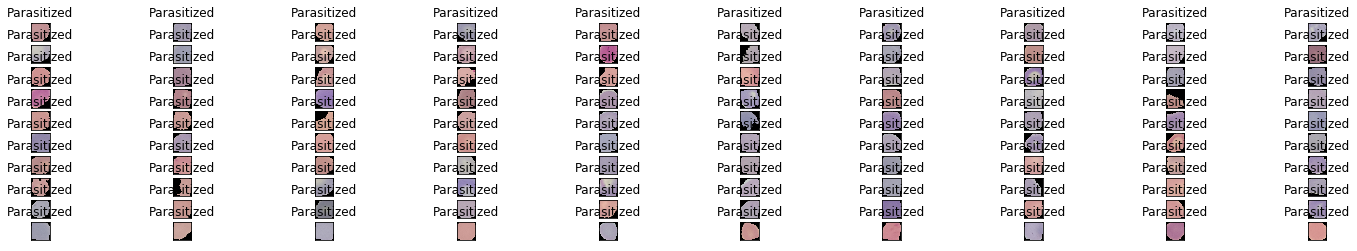

In [54]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(100):
    ax = fig.add_subplot(10, 100/10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Specify Model Architecture

Load the pre-trained model. This time, the VGGNet

In [57]:
#dir(torchvision.models)
model_transfer = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:22<00:00, 24.3MB/s]
